In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
from tqdm import tqdm

In [2]:
_parent_folder = "single_cam_jan_5_2023_3cm"
_folder_name = "sk16_15_quad_fast"
_calib_filename = "calibration_15fps_00"

_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data")

_pth = os.path.join(_base_pth, _parent_folder, _folder_name)
_calib_pth = os.path.join(_base_pth, _parent_folder, _calib_filename)

_video_file_name = "webcam_calibration.msgpack"
_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\single_cam_jan_5_2023_3cm\\sk16_15_quad_fast'

In [3]:
_recorded_folder_list = os.listdir(os.path.join(_base_pth, _parent_folder))
_txt_pth = os.path.join(_base_pth, _parent_folder,"00_analysis", "folder_list.txt")
# with open(_txt_pth, "w") as f:
#     for i in _recorded_folder_list:
#         f.write(i + "\n")

In [4]:
#calibration path
_webcam_calib_pth = os.path.join(_calib_pth, _video_file_name)

#open the calibration files
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)


camera matrix [[844.83674494   0.         365.27912269]
 [  0.         845.06800186 278.18340944]
 [  0.           0.           1.        ]]
distortion [[ 0.10971316 -0.93022571  0.01346217  0.00527896  1.47791377]]


In [5]:
def iter_analysis(_pth, _webcam_cam_mat, _webcam_dist):
    #webcam path
    _webcam_video_pth = os.path.join(_pth, _video_file_name.split("_")[0] + "_color.msgpack")

    #timestamp path
    _webcam_timestamp_pth = os.path.join(_pth, _video_file_name.split("_")[0] + "_timestamp.msgpack")
    _w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=True)
    _w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)
    # get percentage of nan values
    percent_missing = _w_df["x"].isnull().sum() * 100 / len(_w_df["x"])
    total_frames = len(_w_df["x"])
    missing_frames = _w_df["x"].isnull().sum()
    return percent_missing, total_frames, missing_frames

In [6]:
# read foldernames from txt file
with open(_txt_pth, "r") as f:
    _folder_list = f.readlines()
_folder_list = [i.strip() for i in _folder_list]

# create a dataframe to store the data
df = pd.DataFrame(columns = ["folder_name", "total_frames", "missing_frames", "percentage_missing"])

# loop through the folders
_per_missing = []
_total_frame_list = []
_missing_frame_list = []
for i in tqdm(_folder_list):
    _tmp_pth = os.path.join(_base_pth, _parent_folder, i)
    _p, _t, _m = iter_analysis(_tmp_pth, _webcam_cam_mat, _webcam_dist)
    _per_missing.append(_p)
    _total_frame_list.append(_t)
    _missing_frame_list.append(_m)


100%|██████████| 96/96 [21:16<00:00, 13.30s/it]


In [7]:
# check fps value
fps_val = []
for i in _folder_list:
    fps_val.append(int(i.split("_")[1]))

# check speed of movement
speed_val = []
for i in _folder_list:
    speed_val.append(i.split("_")[3])

# check if quad or skateboard
quad_val = []
for i in _folder_list:
    if i.split("_")[2] == "quad":
        quad_val.append("quad")
    else:
        quad_val.append("skateboard")


In [8]:
df["folder_name"] = _folder_list
df["total_frames"] = _total_frame_list
df["missing_frames"] = _missing_frame_list
df["percentage_missing"] = _per_missing
df["fps"] = fps_val
df["speed"] = speed_val
df["object"] = quad_val

In [9]:
# df to csv
df.to_csv(os.path.join(_base_pth, _parent_folder, "00_analysis", "missing_data.csv"), index=False)

In [2]:
# list folder names
# read from csv file
_temp_pth = r"D:\ArUco recordings\single_cam_jan_5_2023_3cm\00_analysis\missing_data.csv"
# df = pd.read_csv(os.path.join(_base_pth, _parent_folder, "00_analysis", "missing_data.csv"))
df = pd.read_csv(_temp_pth)

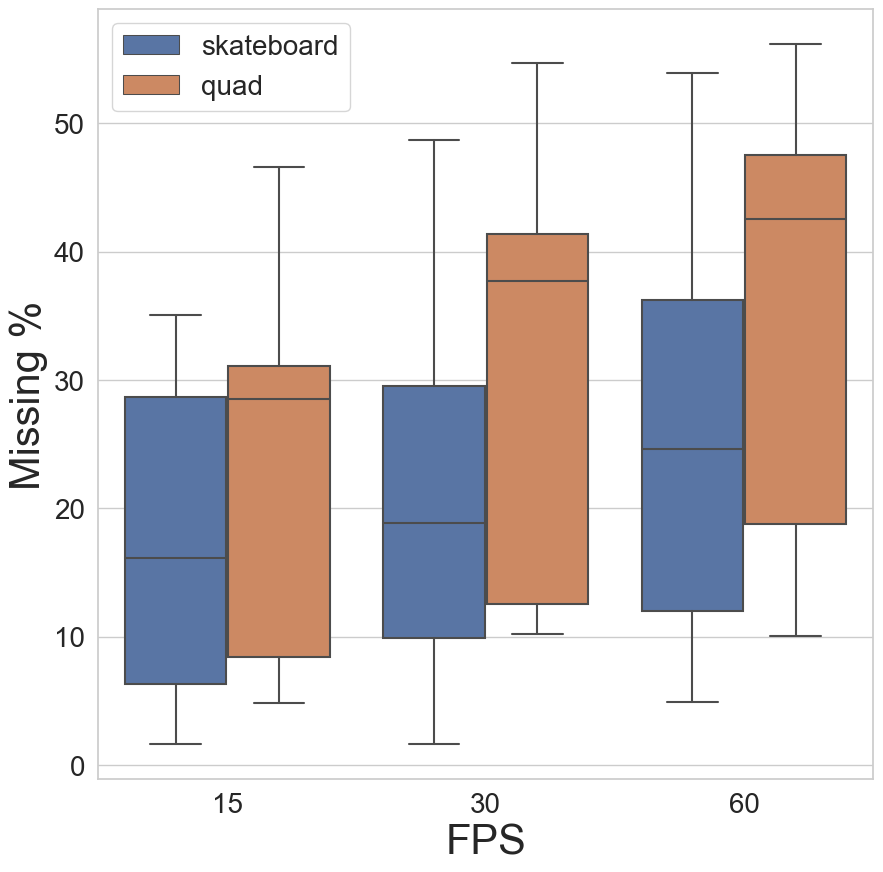

In [5]:
# boxplot
import seaborn as sns
# sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.boxplot(x="fps", y="percentage_missing", hue="object", data=df)

ax.set_xlabel("FPS", fontsize=30)
ax.set_ylabel("Missing %", fontsize=30)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()